In [24]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', 500)

# SIMD

Scottish Index Multiple Deprivation v2 2020

Data: http//simd.scot

Technical Notes: https://www.gov.scot/binaries/content/documents/govscot/publications/statistics/2020/09/simd-2020-technical-notes/documents/simd-2020-technical-notes/simd-2020-technical-notes/govscot%3Adocument/SIMD%2B2020%2Btechnical%2Bnotes.pdf

In [25]:
df_simd_init = pd.read_csv("data/simd_2020.csv", index_col=0)

In [26]:
df_simd_init.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6976 entries, 0 to 6975
Data columns (total 49 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Data_Zone                        6976 non-null   object 
 1   Intermediate_Zone                6976 non-null   object 
 2   Council_area                     6976 non-null   object 
 3   Total_population                 6976 non-null   int64  
 4   Working_Age_population           6976 non-null   int64  
 5   SIMD2020v2_Rank                  6976 non-null   int64  
 6   SIMD_2020v2_Percentile           6976 non-null   int64  
 7   SIMD2020v2_Vigintile             6976 non-null   int64  
 8   SIMD2020v2_Decile                6976 non-null   int64  
 9   SIMD2020v2_Quintile              6976 non-null   int64  
 10  SIMD2020v2_Income_Domain_Rank    6976 non-null   float64
 11  SIMD2020_Employment_Domain_Rank  6976 non-null   float64
 12  SIMD2020_Health_Doma

We can immediately get rid of some columns which will not be useful to us.

- Intermediate_Zone
- Council_area
- any rate columns where we also have count (as we will be including population)
- any ranking columns as these should not be predictive
- percentile, quintile etc

In [27]:
cols_to_drop = ["Intermediate_Zone", "Council_area", "SIMD2020v2_Rank", "SIMD_2020v2_Percentile", "SIMD2020v2_Vigintile", "SIMD2020v2_Decile", "SIMD2020v2_Quintile"]
cols_to_drop += df_simd_init.columns[df_simd_init.columns.str.contains("_Rank")].to_list()
cols_to_drop += ["income_rate", "employment_rate", "crime_rate", "overcrowded_rate"]

df_simd = df_simd_init.drop(cols_to_drop, axis=1)

## Missing Data

The SIMD Technical Notes indicate that wherever "*" is present, this indicates that there was no population relevant to the statistic and a division by 0 occoured in the calculation. Later we will be aggregating this individual data zones into electoral wards and can exclude these data zones from the weighted average calculation. If there are any left then we will deal with them at that stage.

In [28]:
(df_simd=="*").sum()

Data_Zone                   0
Total_population            0
Working_Age_population      0
income_count                0
employment_count            0
CIF                         0
ALCOHOL                     0
DRUG                        0
SMR                         0
DEPRESS                     0
LBWT                        0
EMERG                       0
Attendance                565
Attainment                178
no_qualifications           0
not_participating           0
University                  0
crime_count               500
overcrowded_count           0
nocentralheating_count      0
nocentralheating_rate       0
drive_petrol                0
drive_GP                    0
drive_post                  0
drive_primary               0
drive_retail                0
drive_secondary             0
PT_GP                       0
PT_post                     0
PT_retail                   0
broadband                   0
dtype: int64

Seperately we have some missing data and it is not clear why.

In [29]:
df_simd.isnull().sum()

Data_Zone                  0
Total_population           0
Working_Age_population     0
income_count               0
employment_count           0
CIF                        3
ALCOHOL                    2
DRUG                       2
SMR                        2
DEPRESS                    1
LBWT                       1
EMERG                      2
Attendance                 2
Attainment                11
no_qualifications          0
not_participating          3
University                 2
crime_count                0
overcrowded_count          0
nocentralheating_count     0
nocentralheating_rate      0
drive_petrol               0
drive_GP                   0
drive_post                 0
drive_primary              0
drive_retail               0
drive_secondary            0
PT_GP                      0
PT_post                    0
PT_retail                  0
broadband                  2
dtype: int64

<AxesSubplot:>

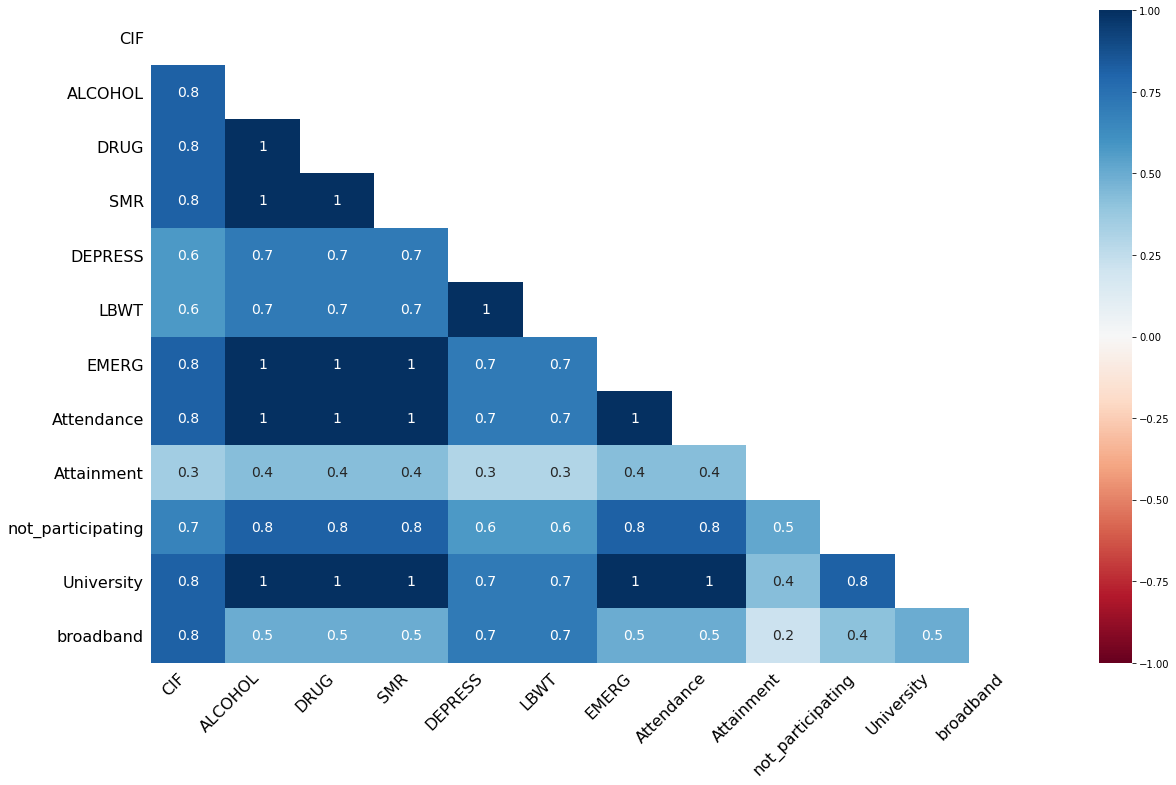

In [30]:
import missingno as msno
msno.heatmap(df_simd)

There is at least some correlation between all of the missing data, and considering how few missing celss there are, this suggests there is some common link. It is probably reasonable to assume there is some sort of systemic cause.

The best approach is probably to treat this missing data as we would the "*" data above and see if this is resovled when we merge the data zones into electoral wards. As we are going to treat the same, we'll turn all "*" into NaN

In [31]:
df_simd[df_simd == "*"] = np.NaN

# Cleaning

## Percentages

Remove "%" sign and divide by 100 to create fraction

In [32]:
percent_cols = ["LBWT", "Attendance", "University", "DEPRESS", "broadband", "nocentralheating_rate","not_participating"]
df_simd[percent_cols] = df_simd[percent_cols].replace("%","",regex=True).astype(float) / 100

## Data Types

Convert remainging object columns to floats where they should be numbers

In [33]:
df_simd[["Attainment", "crime_count"]] = df_simd[["Attainment", "crime_count"]].astype(float)

# Data Zones to Electoral Wards#

We need to convert the data from the small data zones, to the larger electoral wards.

## Merge Ward Codes

The electoral ward for each data zone is listed in wards.csv. First we want to add the wards data to the simd data frame.

In [34]:
df_wards = pd.read_csv("data/wards.csv")

In [35]:
df_simd = df_simd.merge(right=df_wards[["zone_code","ward_code"]], left_on="Data_Zone", right_on="zone_code")
df_simd = df_simd.drop("zone_code", axis=1)

In [36]:
df_simd

,Data_Zone,Total_population,Working_Age_population,income_count,employment_count,CIF,ALCOHOL,DRUG,SMR,DEPRESS,LBWT,EMERG,Attendance,Attainment,no_qualifications,not_participating,University,crime_count,overcrowded_count,nocentralheating_count,nocentralheating_rate,drive_petrol,drive_GP,drive_post,drive_primary,drive_retail,drive_secondary,PT_GP,PT_post,PT_retail,broadband,ward_code
0,S01006506,894,580,71,49,65.0,29.0,30.0,70.0,0.13,0.00,74.0,0.85,5.88,53.0,0.00,0.30,11.0,87,10,0.01,2.540103,3.074295,1.616239,2.615747,1.544260,9.930833,8.863589,5.856135,6.023406,0.11,S13002843
1,S01006507,793,470,43,25,45.0,130.0,126.0,81.0,0.14,0.00,86.0,0.85,5.96,96.0,0.02,0.12,10.0,85,4,0.00,3.915072,4.309812,2.555858,3.646697,2.849656,11.042816,9.978272,7.515000,7.926029,0.01,S13002843
2,S01006508,624,461,40,19,45.0,71.0,18.0,41.0,0.13,0.04,69.0,0.90,5.75,39.0,0.01,0.19,8.0,31,8,0.01,3.323025,3.784549,1.440991,3.247325,2.062255,10.616768,8.620700,4.321493,5.770910,0.01,S13002843
3,S01006509,537,307,52,26,80.0,80.0,28.0,103.0,0.16,0.05,88.0,0.94,6.20,80.0,0.00,0.25,4.0,42,6,0.01,2.622991,2.778026,2.620681,1.936908,2.160142,10.036471,7.935112,8.433328,8.329819,0.11,S13002843
4,S01006510,663,415,68,32,95.0,89.0,44.0,139.0,0.22,0.05,89.0,0.80,5.87,77.0,0.06,0.16,11.0,50,7,0.01,2.115004,2.358335,2.408416,1.845672,1.784635,9.650000,5.568964,6.966429,6.632609,0.00,S13002843
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6971,S01013477,612,355,80,39,120.0,135.0,75.0,56.0,0.24,0.00,105.0,0.81,5.13,130.0,0.15,0.02,13.0,93,10,0.02,2.732500,3.706674,1.690504,3.148465,1.559616,5.930057,7.693930,4.175574,4.284855,0.00,S13002821
6972,S01013478,817,582,74,48,100.0,114.0,114.0,79.0,0.18,0.03,112.0,0.83,5.70,92.0,0.01,0.08,29.0,87,1,0.00,5.227738,1.922628,1.977860,2.979797,2.815971,3.425031,6.550913,6.485256,7.598948,0.00,S13002821
6973,S01013479,785,479,144,75,140.0,208.0,276.0,109.0,0.27,0.09,127.0,0.76,5.17,137.0,0.12,0.03,44.0,96,9,0.01,3.664326,3.613521,1.657220,2.530326,1.445423,5.912698,7.355121,4.006667,4.412252,0.01,S13002821
6974,S01013480,677,410,54,35,130.0,77.0,23.0,88.0,0.19,0.07,108.0,0.75,5.68,173.0,0.01,0.05,7.0,107,1,0.00,3.251885,4.625972,2.600421,3.541645,2.127917,6.626376,10.176170,6.409534,6.928539,0.00,S13002821


## Combine Zone Data into Wards

We will use population to perform a weighted average of all features to get ward statisitics from data zones.

$$\bar{x}_{ward} =\frac{\sum_{i=1}^{zones}w_ix_i}{\sum_{i=1}^{zones}w_i}$$

Where zones are all the zones in that ward.

The extra consideration is where we have a missing value we need to exclude this feature for that zone from the weighted mean calculation.

Our approach here is to create two dataframes:

1. Values - the value of each example for each feature, here it is df_simd

2. Weights - this will have the population for each zone repeated across each feature, except where the a zone is missing data for a feature where we will set the weight (population) to zero.

We can make use of the group_by function to get a sum over each ward



In [37]:
#move ward code to front of dataframe
ward_code = df_simd["ward_code"]
df_simd = df_simd.drop("ward_code", axis=1)
df_simd.insert(loc=1, column="ward_code", value=ward_code)

In [38]:
#get list of columns that are getting averaged
cols_to_average = df_simd.columns.drop(["Total_population", "Working_Age_population", "ward_code", "Data_Zone"])


#WEIGHTS
#population as a series
s_pop = df_simd["Total_population"].copy()
#insert population where there are not nulls
df_weights = df_simd[cols_to_average].copy()
df_weights = df_weights.where(df_weights.isnull(), s_pop, axis=0) #replace all non-nulls with population figure
#makes nulls equal to 0, probably doesn't make a difference
df_weights = df_weights.replace(np.nan,0)

#VALUES
df_values = df_simd[cols_to_average].copy()

#WEIGHTED AVERAGE
#multiply and groupby.sum to get top part of weighted average equation
df_weights_x_values = df_weights * df_values
df_weights_x_values.insert(loc=0, column="ward_code", value=ward_code)#re-insert ward codes
df_weights_x_values = df_weights_x_values.groupby("ward_code").sum()

#sum up weights to get bottom half of weighted average equation
df_weights.insert(loc=0, column="ward_code", value=ward_code)
df_weights = df_weights.groupby("ward_code").sum()

#finally, divide top and bottom
df_simd_ward = df_weights_x_values / df_weights

#sum up two population colums
df_pop_sum = df_simd[["ward_code","Total_population", "Working_Age_population"]].groupby("ward_code").sum()

#add population columns to new ward simd dataframe
df_simd_ward.insert(loc=0, column="Total_population", value=df_pop_sum["Total_population"])
df_simd_ward.insert(loc=1, column="Working_Age_population", value=df_pop_sum["Working_Age_population"])

df_simd_ward = df_simd_ward.reset_index()


In [39]:
df_simd_ward

,ward_code,Total_population,Working_Age_population,income_count,employment_count,CIF,ALCOHOL,DRUG,SMR,DEPRESS,LBWT,EMERG,Attendance,Attainment,no_qualifications,not_participating,University,crime_count,overcrowded_count,nocentralheating_count,nocentralheating_rate,drive_petrol,drive_GP,drive_post,drive_primary,drive_retail,drive_secondary,PT_GP,PT_post,PT_retail,broadband
0,S13002516,6111,3478,94.042710,41.328261,110.153003,114.805433,22.790542,99.169039,0.192381,0.076868,92.658157,0.849956,5.476032,119.897234,0.040412,0.060825,21.085505,53.753886,30.178694,0.040327,3.946476,4.551598,2.728569,2.980182,3.854868,6.434311,10.633718,8.261358,10.243203,0.141340
1,S13002517,6401,3714,58.595376,26.339166,81.617716,103.080769,23.825808,98.061084,0.180906,0.028839,80.676144,0.817787,5.542611,93.151539,0.013887,0.111651,6.868186,57.934541,30.390564,0.043374,8.631041,5.411644,3.896444,5.187262,16.379629,21.827338,14.157198,10.316684,29.706465,0.358639
2,S13002518,7484,4464,65.432122,32.331908,75.618653,86.048503,12.591796,95.996526,0.178457,0.045146,83.549172,0.855048,5.545504,69.452699,0.023932,0.111996,14.581402,47.939337,36.187467,0.044441,7.975794,8.939301,6.533639,4.297461,8.911027,15.592332,20.059844,14.952642,18.331150,0.190697
3,S13002519,10481,6494,64.697548,31.658334,84.460452,134.482969,85.785898,97.371625,0.173713,0.037029,92.695353,0.813101,5.639084,86.322011,0.020125,0.084689,21.759004,67.320771,40.240721,0.055011,8.655115,9.364620,4.522625,6.099660,14.346795,17.297806,15.973446,10.114409,20.631315,0.194563
4,S13002520,9696,5910,49.884076,24.288057,67.383973,85.330239,38.025268,92.584158,0.162376,0.034471,83.904703,0.831668,5.499323,74.474010,0.014362,0.082103,11.836036,58.506188,36.371287,0.051683,12.907514,11.009297,6.592081,6.919438,20.383678,24.449629,24.667160,15.891275,36.810837,0.342821
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
349,S13003130,18858,11720,153.301251,72.150069,148.231255,131.371726,157.648425,115.093965,0.227230,0.063487,122.261534,0.738181,5.186727,155.321243,0.067860,0.038604,23.178545,86.439919,3.381589,0.004228,6.703038,2.306326,1.837708,2.345254,3.643698,6.807670,7.069065,5.883331,8.195946,0.032208
350,S13003131,15463,9612,81.039578,42.541939,94.643342,92.741512,63.888573,98.839035,0.208104,0.056502,92.714415,0.838742,5.456752,104.427925,0.036580,0.080470,11.262716,54.654465,4.868719,0.005258,6.494383,3.605717,2.523312,2.756397,13.042172,13.905737,9.047529,7.099710,23.742511,0.062950
351,S13003132,13914,8370,45.238393,21.749677,53.283743,24.894064,52.205476,70.934670,0.144314,0.052781,75.823200,0.881881,5.886444,52.716113,0.015203,0.156407,7.451978,36.177950,11.639931,0.014192,3.763855,5.287703,3.834895,3.426302,6.182912,6.957981,13.642856,10.779433,15.502416,0.235170
352,S13003133,20841,13802,210.784895,100.173696,195.468787,180.169810,148.566048,145.464373,0.247953,0.058712,165.099707,0.739144,5.064032,222.412744,0.049471,0.056824,34.334005,168.589031,29.765606,0.039486,3.671426,2.799895,2.291515,2.842017,4.357467,5.158811,8.046771,7.539099,10.710887,0.037363


## Missing Data Part 2

Now that we have merged our data zones into electral wards, do we still have any missing data?

In [40]:
df_simd_ward.isnull().sum()

ward_code                 0
Total_population          0
Working_Age_population    0
income_count              0
employment_count          0
CIF                       0
ALCOHOL                   0
DRUG                      0
SMR                       0
DEPRESS                   0
LBWT                      0
EMERG                     0
Attendance                0
Attainment                0
no_qualifications         0
not_participating         0
University                0
crime_count               2
overcrowded_count         0
nocentralheating_count    0
nocentralheating_rate     0
drive_petrol              0
drive_GP                  0
drive_post                0
drive_primary             0
drive_retail              0
drive_secondary           0
PT_GP                     0
PT_post                   0
PT_retail                 0
broadband                 0
dtype: int64

Yes! We have 2 crime_count examples without values.

In [41]:
df_simd_ward.loc[df_simd_ward['crime_count'].isnull()]

,ward_code,Total_population,Working_Age_population,income_count,employment_count,CIF,ALCOHOL,DRUG,SMR,DEPRESS,LBWT,EMERG,Attendance,Attainment,no_qualifications,not_participating,University,crime_count,overcrowded_count,nocentralheating_count,nocentralheating_rate,drive_petrol,drive_GP,drive_post,drive_primary,drive_retail,drive_secondary,PT_GP,PT_post,PT_retail,broadband
22,S13002604,2191,1301,46.561844,26.499315,80.780466,61.876312,15.507987,70.497946,0.163692,0.065253,89.163396,0.898393,5.918097,72.449566,0.018371,0.087339,NaN,11.905979,24.183478,0.032661,14.837709,15.900999,3.780939,5.744639,17.025573,16.197091,25.966401,10.294969,29.995440,0.126855
44,S13002772,2743,1503,43.251914,15.355086,53.680277,38.051404,19.428363,93.051404,0.152858,0.023901,57.641998,0.895691,5.833788,87.610281,0.011345,0.066511,NaN,21.543201,36.315348,0.046825,10.955874,13.056920,4.995294,4.678997,92.234020,9.963795,31.212228,17.047425,185.921743,0.765071


It is unclear why this data is missing. We don't want to drop the column and we don't want to exclude the electoral wards from our predictor, so we will need to create some values. To do this will use a KNN imputer.

In [42]:
from sklearn.impute import KNNImputer

impute_knn = KNNImputer(n_neighbors=3, weights="distance")
arr_knn = impute_knn.fit_transform(df_simd_ward.drop("ward_code",axis=1))
df_knn = pd.DataFrame(data=arr_knn, columns=df_simd_ward.drop("ward_code",axis=1).columns)

In [43]:
df_knn.insert(loc=0, column="ward_code", value=ward_code)
df_knn.loc[df_simd_ward['crime_count'].isnull()]

,ward_code,Total_population,Working_Age_population,income_count,employment_count,CIF,ALCOHOL,DRUG,SMR,DEPRESS,LBWT,EMERG,Attendance,Attainment,no_qualifications,not_participating,University,crime_count,overcrowded_count,nocentralheating_count,nocentralheating_rate,drive_petrol,drive_GP,drive_post,drive_primary,drive_retail,drive_secondary,PT_GP,PT_post,PT_retail,broadband
22,S13002845,2191.0,1301.0,46.561844,26.499315,80.780466,61.876312,15.507987,70.497946,0.163692,0.065253,89.163396,0.898393,5.918097,72.449566,0.018371,0.087339,22.641001,11.905979,24.183478,0.032661,14.837709,15.900999,3.780939,5.744639,17.025573,16.197091,25.966401,10.294969,29.995440,0.126855
44,S13002844,2743.0,1503.0,43.251914,15.355086,53.680277,38.051404,19.428363,93.051404,0.152858,0.023901,57.641998,0.895691,5.833788,87.610281,0.011345,0.066511,4.019151,21.543201,36.315348,0.046825,10.955874,13.056920,4.995294,4.678997,92.234020,9.963795,31.212228,17.047425,185.921743,0.765071
